<a href="https://colab.research.google.com/github/farheenfathimaa/NLP-with-Disaster-Tweets/blob/main/Natural_Language_Processing_with_Disaster_Tweets_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
# Unzip the uploaded data into Google Drive
#!unzip "/content/drive/MyDrive/nlp-getting-started.zip" -d "/content/drive/MyDrive/nlp-tweets"

# Natural Language Processing with Disaster Tweets

This notebook looks into various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

It is available on Kaggle. [Link](https://www.kaggle.com/competitions/nlp-getting-started/overview)



In [3]:
#!pip install tensorflow

The code below is the copy of [Link](https://www.kaggle.com/code/nabeelparuk/nlp-disaster-tweet-sentiment-analysis)

This is attempt of understanding the real time working on a NLP problem

## Importing modules

In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Embedding
import tensorflow_hub as hub
#import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import random
import datetime
import matplotlib.pyplot as plt
import io
from IPython.display import FileLink

import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis
### Import data

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/nlp-tweets/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/nlp-tweets/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df_shuffled = train_df.sample(frac=1, random_state=1)
train_df_shuffled.head()

,id,keyword,location,text,target
3228,4632,emergency%20services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\nThese wounds they will no...,1


In [7]:
train_df.isna().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [8]:
train_df["target"].value_counts()

,count
target,
0,4342
1,3271


In [9]:
# Visualising few samples
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target>0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
@heebsterrr_ I remember the heat wave the year I went bruh and they don't have AC ????

---

Target: 1 (real disaster)
Text:
Japan Marks 70th Anniversary of Hiroshima Atomic Bombing http://t.co/3EV07PPaPn

---

Target: 1 (real disaster)
Text:
There's a Storm over Cairo in the latest 'X-Men Apocalypse' set photo https://t.co/fS012trUDG via @YahooTV

---

Target: 0 (not real disaster)
Text:
å_? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/zujwUiomb3 http://t.co/YklTFj1FnC

---

Target: 1 (real disaster)
Text:
Governor allows parole for California school bus hijacker who kidnapped 26 children in 1976. http://t.co/hdAhLgrprl http://t.co/Z1s3T77P3L

---



## Preprocessing
### Split into training and validation data

In [10]:
# Set target and predictors
X = train_df_shuffled["text"].to_numpy()
y = train_df_shuffled["target"].to_numpy()

# Split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  random_state=42,
                                                  test_size=0.2)

###Text vectorization

In [11]:
# Find average number of tokens in tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

15

In [12]:
# Set custom parameters
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=max_length)
text_vectorizer.adapt(X_train)

In [13]:
# Test on random sentence
random_sentence = random.choice(X_train)
print(f"Text:\n{random_sentence}\n\nAfter vectorization:\n{text_vectorizer([random_sentence])}")

Text:
70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b...  http://t.co/BS6XaqHsim

After vectorization:
[[ 292  130   36  214 1040  225   86 1238   15  119  418    2  413    6
     2]]


Let's look at some common words

In [14]:
# Get common values
vocab_words = text_vectorizer.get_vocabulary()

# Get the least and the most common words
most_common = vocab_words[:5]
least_common = vocab_words[-5:]
print(f"Most common: {most_common}\nLeast_common: {least_common}")

Most common: ['', '[UNK]', 'the', 'a', 'in']
Least_common: ['mildmannered', 'milc5040h', 'mil', 'mikecroninwmur', 'mihirssharma']


## Embedding
We use embedding to make the vectorized text learnable

In [15]:
# Create embedding layer
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length,
                             name="embedding_1")

In [16]:
# Choose random sentence
random_sentence = random.choice(X_train)
print("Original sentence:", random_sentence)

# Embed sentence -> can't use straight text
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original sentence: Hollywood movie about trapped miners released in Chile http://t.co/YeLJPQHmEd


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04749724,  0.00523769, -0.0498977 , ..., -0.00776069,
          0.04219303,  0.00498431],
        [ 0.03073844, -0.02209297, -0.02431502, ..., -0.0082309 ,
         -0.0336802 ,  0.04460658],
        [ 0.04355048, -0.02876543, -0.00120461, ..., -0.03238872,
         -0.02795857, -0.00559012],
        ...,
        [-0.00223953,  0.02867765,  0.00963435, ...,  0.00445111,
         -0.00604109, -0.00064392],
        [-0.00223953,  0.02867765,  0.00963435, ...,  0.00445111,
         -0.00604109, -0.00064392],
        [-0.00223953,  0.02867765,  0.00963435, ...,  0.00445111,
         -0.00604109, -0.00064392]]], dtype=float32)>

## Model Construction
Define useful functions

*Metrics dictionary*

In [17]:
def metrics_dict(y_true, y_preds):
  """Gives the accuracy, precision, recall and f1 score"""
  acc = accuracy_score(y_true, y_preds)
  prec = precision_score(y_true, y_preds)
  recall = recall_score(y_true, y_preds)
  f1 = f1_score(y_true, y_preds, average="weighted")

  metrics = {"Accuracy":acc,
             "Precision":prec,
             "Recall":recall,
             "F1 Score":f1}
  return metrics

*TensorBoard Callback*

In [18]:
def create_tensorboard_callback(dir_name, exp_name):
  """
  Create a TensorBoard callback to store log files

  Store log files with filepath:
  "dir_name/exp_name/current_datetime"

  Args:
    dir_name: Target directory
    exp_name: Name of the experiment directory
  """
  log_dir = dir_name + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

SAVE_DIR = "/content/drive/MyDrive/nlp-tweets/model_logs"

## Model 0 | Naive Bayes | Baseline Model
### Build model

In [19]:
# Create vectorizer
bayes_vectorizer = TfidfVectorizer()

# Build pipeline
model_0 = Pipeline([
    ("tfidf", bayes_vectorizer),
    ("clf", MultinomialNB())
])

# Fit the model
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

###Evaluate model

In [20]:
# Get predictions
model_0_preds = model_0.predict(X_val)

# Compute metrics
model_0_metrics = metrics_dict(y_val, model_0_preds)
model_0_metrics

{'Accuracy': 0.8089297439264609,
 'Precision': 0.8636363636363636,
 'Recall': 0.6363636363636364,
 'F1 Score': 0.8025095513670459}

## Model 1 | Feed-forward Neural Network
### Build Model

In [21]:
# Build model (using fuctional API)
inputs = layers.Input(shape=(1, ), dtype=tf.string)

# Turn text into numbers
x = text_vectorizer(inputs)
x = embedding(x)

# Hidden layers
x = layers.GlobalAveragePooling1D()(x)

# Output layers
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs,
                         outputs,
                         name="model_1_feedforward")

# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_1 = model_1.fit(x=X_train,
                        y=y_train,
                        validation_data=(X_val, y_val),
                        epochs=5,
                        callbacks=[create_tensorboard_callback(SAVE_DIR,model_1.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/model_1_feedforward/20240830-053828
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6350 - loss: 0.6578 - val_accuracy: 0.7649 - val_loss: 0.5307
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8059 - loss: 0.4839 - val_accuracy: 0.8004 - val_loss: 0.4615
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8594 - loss: 0.3643 - val_accuracy: 0.7991 - val_loss: 0.4520
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8871 - loss: 0.2952 - val_accuracy: 0.7997 - val_loss: 0.4498
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9068 - loss: 0.2475 - val_accuracy: 0.8030 - val_loss: 0.4659


In [22]:
model_1.summary()

Model: "model_1_feedforward"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

### Evaluate model

In [23]:
# Get predictions
model_1_pred_probs = model_1.predict(X_val)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

# Compute metrics
model_1_metrics = metrics_dict(y_val, model_1_preds)
model_1_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


{'Accuracy': 0.8030203545633617,
 'Precision': 0.8067542213883677,
 'Recall': 0.6858054226475279,
 'F1 Score': 0.7999481073965842}

<Figure size 640x480 with 0 Axes>

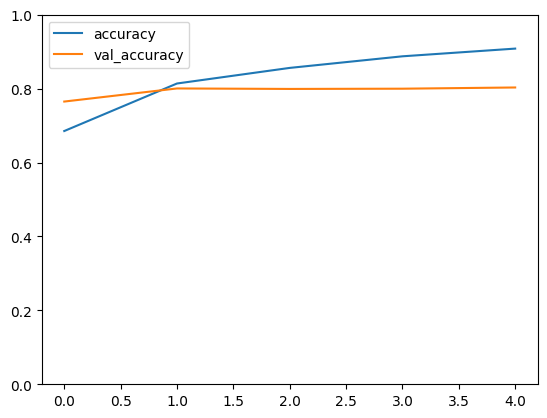

In [24]:
# Plot accuracy curves
history1_plot = pd.DataFrame(history_1.history)

plt.figure()
history1_plot.loc[ : ,["accuracy", "val_accuracy"]].plot()
plt.ylim(0,1);

### Visualise learned embedding
*Navigate to [TensorFlow Embedding Projector](https://projector.tensorflow.org/)*

In [25]:
# Get vocobulary
words_in_vocab = text_vectorizer.get_vocabulary()

# Get weight metrix of embeddign layer
embed_weights_model_1 = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights_model_1.shape)

(10000, 128)


### Download the files

In [26]:
# Create output writers
out_v = io.open("embedding_vectors_model1.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata_model1.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to files
for num, word in enumerate(words_in_vocab):
  if num==0:
    continue # skip padding token
  vec = embed_weights_model_1[num]
  out_m.write(word +"\n") # word to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

### Generate download links

In [27]:
FileLink("embedding_vectors.tsv")

/content/embedding_vectors.tsv

In [28]:
FileLink("embedding_metadata.tsv")

/content/embedding_metadata.tsv

##Model 2 | LSTM
###Build Model

In [31]:
# input
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Turn text into numbers
x = text_vectorizer(inputs)
x = embedding(x)

# Hidden layers
x = layers.LSTM(128)(x)
x = layers.Dense(128)(x)

# Output layers
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs,
                        outputs,
                        name="model_2_lstm")

# compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history2 = model_2.fit(X_train,
                       y_train,
                       validation_data=[X_val, y_val],
                       epochs=10,
                       callbacks=[create_tensorboard_callback(SAVE_DIR, model_2.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/model_2_lstm/20240830-055959
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9138 - loss: 0.2504 - val_accuracy: 0.7518 - val_loss: 0.6037
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9463 - loss: 0.1502 - val_accuracy: 0.7958 - val_loss: 0.5734
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9601 - loss: 0.1199 - val_accuracy: 0.7590 - val_loss: 0.9451
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9651 - loss: 0.0893 - val_accuracy: 0.7787 - val_loss: 0.8719
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9738 - loss: 0.0741 - val_accuracy: 0.7774 - val_loss: 0.8475
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9752 - loss: 0.0702 - val_accuracy: 0.7794 - val_loss: 1.2164
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9759 - loss: 0.0640 - val_accuracy: 0.7702 - val_loss:

In [32]:
model_2.summary()

Model: "model_2_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,284,677 (16.34 MB)

 Trainable params: 1,428,225 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,856,452 (10.90 MB)

###Evaluate the model

In [33]:
# Get predictions
model_2_pred_probs = model_2.predict(X_val)
model_2_preds = tf.squeeze(tf.round((model_2_pred_probs)))

# Compute metrics
model_2_metrics = metrics_dict(y_val, model_2_preds)
model_2_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


{'Accuracy': 0.768220617202889,
 'Precision': 0.7238562091503268,
 'Recall': 0.7065390749601276,
 'F1 Score': 0.76777960059734}

<Figure size 640x480 with 0 Axes>

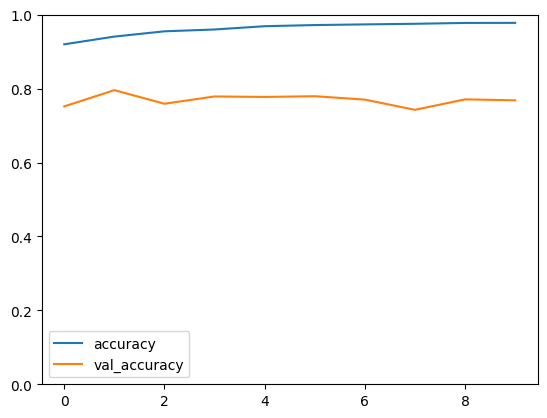

In [34]:
# Plot accuracy curves
history2_plot = pd.DataFrame(history2.history)

plt.figure()
history2_plot.loc[:,["accuracy", "val_accuracy"]].plot()
plt.ylim(0,1);

Still some overfitting
## Model 3 | GRU-Cell Powered RNN
The GRU-Cell Powered RNN (Recurrent Neural Network) is a type of RNN architecture that utilizes the Gated Recurrent Unit (GRU) cell as its building block.

**GRU Cell:**

* **Update Gate:** Controls how much information from the previous state should be passed to the current state.
* **Reset Gate:** Determines how much of the previous state should be forgotten when calculating the current state.
* **Output Gate:** Controls the amount of information from the current state that is passed to the next state.

**GRU-Cell Powered RNN:**

**Advantages:**
* Simpler than LSTM (Long Short-Term Memory) cells, making them computationally efficient.
Effective in capturing long-term dependencies in sequential data.
* Can be used for various tasks like language modeling, machine translation, and speech recognition.

**Disadvantages:**
* May not be as powerful as LSTM cells in certain scenarios, especially when dealing with complex sequential patterns.

> ***Overall, GRU-Cell Powered RNNs offer a good balance between performance and computational efficiency, making them a popular choice for many sequence-to-sequence tasks.***

###Build Model

In [39]:
# Input layer
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Turn text into numbers
x = text_vectorizer(inputs)
x = embedding(x)

# Hidden layers
x = layers.GRU(128)(x)
x = layers.Dense(128)(x)

# Output layers
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs,
                         outputs,
                         name="model_3_GRU")

# compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history3 = model_3.fit(X_train,
                       y_train,
                       validation_data=[X_val, y_val],
                       epochs=10,
                       callbacks=[create_tensorboard_callback(SAVE_DIR, model_3.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/model_3_GRU/20240830-063653
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8974 - loss: 0.2036 - val_accuracy: 0.7774 - val_loss: 0.8941
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9760 - loss: 0.0609 - val_accuracy: 0.7656 - val_loss: 1.1574
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9811 - loss: 0.0426 - val_accuracy: 0.7571 - val_loss: 1.9719
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9848 - loss: 0.0362 - val_accuracy: 0.7649 - val_loss: 1.4078
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9756 - loss: 0.0498 - val_accuracy: 0.7577 - val_loss: 1.9206
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9814 - loss: 0.0371 - val_accuracy: 0.7439 - val_loss: 1.7129
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9846 - loss: 0.0299 - val_accuracy: 0.7374 - val_loss: 1

In [40]:
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,187,141 (15.97 MB)

 Trainable params: 1,395,713 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,791,428 (10.65 MB)

###Evaluate model

In [42]:
# Get predictions
model_3_pred_probs = model_3.predict(X_val)
model_3_preds = tf.squeeze(tf.round((model_3_pred_probs)))

# Compute metrics
model_3_metrics = metrics_dict(y_val, model_3_preds)
model_3_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


{'Accuracy': 0.7511490479317138,
 'Precision': 0.7108843537414966,
 'Recall': 0.6666666666666666,
 'F1 Score': 0.749805386015765}

<Figure size 640x480 with 0 Axes>

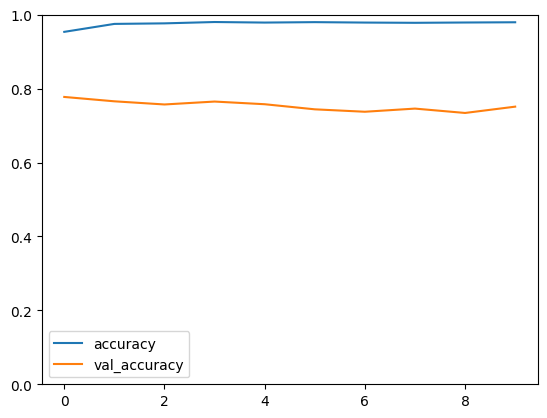

In [43]:
# plot accuracy curves
history3_plot = pd.DataFrame(history3.history)

plt.figure()
history3_plot.loc[:,["accuracy", "val_accuracy"]].plot()
plt.ylim(0,1);

##Model 4 | Bidirectional Neural Network
The LSTM clearly outperformed the GRU so we are going to use that in conjunction with the BiNN

### Build model

In [49]:
# Input layer
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Turn string to numbers
x = text_vectorizer(inputs)
x = embedding(x)

# Hidden layer
x = layers.Bidirectional(layers.LSTM(128))(x)
x = layers.Dense(128)(x)

# Output layer
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs,
                         outputs,
                         name="Model_4_binn")

# compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history4 = model_4.fit(X_train,
                       y_train,
                       validation_data=[X_val, y_val],
                       epochs=10,
                       callbacks=[create_tensorboard_callback(SAVE_DIR, model_4.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/Model_4_binn/20240830-071711
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9706 - loss: 0.1223 - val_accuracy: 0.7571 - val_loss: 1.3761
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9851 - loss: 0.0344 - val_accuracy: 0.7564 - val_loss: 1.4342
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9824 - loss: 0.0358 - val_accuracy: 0.7387 - val_loss: 2.3415
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9826 - loss: 0.0333 - val_accuracy: 0.7236 - val_loss: 1.8492
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9781 - loss: 0.0338 - val_accuracy: 0.7308 - val_loss: 2.0449
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9836 - loss: 0.0308 - val_accuracy: 0.7380 - val_loss: 2.2508
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9794 - loss: 0.0379 - val_accuracy: 0.7360 - val_los

In [50]:
model_4.summary()

Model: "Model_4_binn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,728,581 (18.04 MB)

 Trainable params: 1,576,193 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,152,388 (12.03 MB)

### Evaluate model

In [51]:
# Get predictions
model_4_pred_probs = model_4.predict(X_val)
model_4_preds = tf.squeeze(tf.round((model_4_pred_probs)))

# Compute the metrics
model_4_metrics = metrics_dict(y_val, model_4_preds)
model_4_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


{'Accuracy': 0.7485226526592252,
 'Precision': 0.6936507936507936,
 'Recall': 0.696969696969697,
 'F1 Score': 0.7486118919569124}

<Figure size 640x480 with 0 Axes>

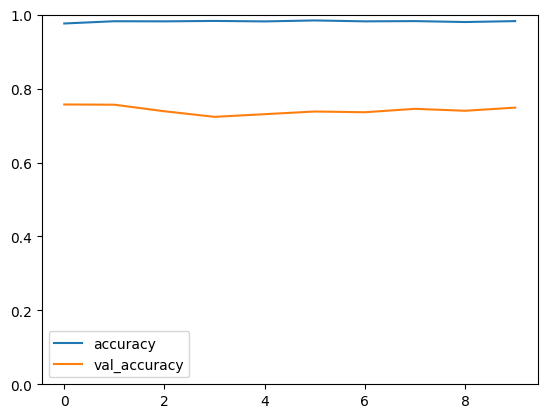

In [52]:
# plot the accuracy curve
history4_plot = pd.DataFrame(history4.history)

plt.figure()
history4_plot.loc[:, ["accuracy", "val_accuracy"]].plot()
plt.ylim(0,1);

## Model 5 | CNN
### Build Model